In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Added for confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoids warning from tokenizer when using num_workers > 0 in DataLoader

# Encoder-only Transformer for Text Sentiment Classification

## 1. Data

### 1.1 Load the IMDB dataset

We will use the IMDB dataset for sentiment classification. The dataset consists of 50,000 movie reviews, each labeled as positive or negative. We will use 25k reviews for training, 5k for validation, and 20k for testing.

In [2]:
# Constants
SEED = 420
VAL_SIZE = 0.2

# Load IMDB dataset
dataset_train = load_dataset("imdb", split="train")
dataset_test = load_dataset("imdb", split="test")

# Split test into test and validation
dataset_test = dataset_test.train_test_split(test_size=1-VAL_SIZE, seed=SEED)
dataset_test, dataset_val = dataset_test["test"], dataset_test["train"]

print(f"Train size: {len(dataset_train)}")
print(f"Validation size: {len(dataset_val)}")
print(f"Test size: {len(dataset_test)}")

Train size: 25000
Validation size: 5000
Test size: 20000


### 1.2 Preprocess the data

We remove HTML tags, special characters, and convert the text to lowercase.

In [3]:
def remove_html_tags(text):
    # Remove HTML tags
    return re.sub(r'<[^>]*>', '', text)

def remove_special_characters(text):
    # Remove special characters except for ,.!? and space
    return re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)

def to_lowercase(text):
    # Convert text to lowercase
    return text.lower()

def preprocess_text(text):
    # Apply all preprocessing steps to the text
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    return text

def preprocess_batch(examples):
    # Apply preprocessing to all texts in the batch
    examples["text"] = [preprocess_text(text) for text in examples["text"]]
    return examples

# Preprocess the dataset
dataset_train = dataset_train.map(preprocess_batch, batched=True)
dataset_val = dataset_val.map(preprocess_batch, batched=True)
dataset_test = dataset_test.map(preprocess_batch, batched=True)

### 1.3 Tokenization

We use a simple word-level tokenizer to tokenize the text data. We use three special tokens: `[PAD]`, `[UNK]` and `[CLS]`. The `[PAD]` token will be used to pad the input sequences to the same length. The `[UNK]` token is used to represent out-of-vocabulary words (rare words). When classifying text, we will prepend the `[CLS]` token to the input sequence and use its output as the representation of the whole sequence.

To reduce the vocabulary size, we only keep words appearing at least `MIN_FREQUENCY` times in the training set.

In [4]:
# Special tokens (padding, unknown, classification)
PAD_TOKEN = "[PAD]"
UNK_TOKEN = "[UNK]"
CLS_TOKEN = "[CLS]"
MIN_FREQUENCY = 10
VOCAB_SIZE = 10000

# Tokenizer setup
tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
tokenizer.pre_tokenizer = Whitespace() # Split on whitespace

# Train tokenizer on the training set
trainer = WordLevelTrainer(special_tokens=[PAD_TOKEN, UNK_TOKEN, CLS_TOKEN], min_frequency=MIN_FREQUENCY, vocab_size=VOCAB_SIZE)
tokenizer.train_from_iterator(dataset_train["text"], trainer)

We test the tokenizer on a few examples to verify that it works as expected.

In [5]:
for idx in range(5):
    example = dataset_train[idx]
    original_text = example["text"]
    tokenized_text = tokenizer.encode(example["text"])
    decoded_text = tokenizer.decode(tokenized_text.ids, skip_special_tokens=False)

    print(f"Original text: {original_text}")
    print(f"Tokenized text (tokens): {tokenized_text.tokens}")
    print(f"Tokenized text (IDs): {tokenized_text.ids}")
    print(f"Decoded text: {decoded_text}")
    print()

Original text: i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u.s. customs if it ever tried to enter this country, therefore being a fan of films considered controversial i really had to see this for myself.the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.what kills me about i am curiousyellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then its no

We plot the distribution of the sequence lengths in the training set. Later, we can use this to determine the maximum sequence length to use.

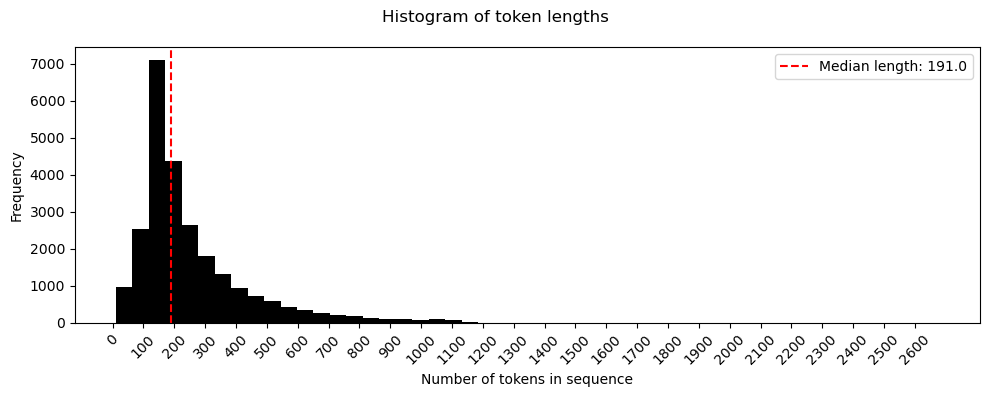

In [6]:
# Histogram of token lengths
token_lengths = [len(tokenizer.encode(text).ids) for text in dataset_train["text"]]
median_length = np.median(token_lengths)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_lengths, bins=50, color="black")
ax.set_xticks(np.arange(0, np.max(token_lengths) + 1, 100))
ax.tick_params(axis="x", labelrotation=45)
ax.set_xlabel("Number of tokens in sequence")
ax.set_ylabel("Frequency")
ax.axvline(median_length, color="red", linestyle="--", label=f"Median length: {median_length}")
ax.legend()
fig.suptitle("Histogram of token lengths")
fig.tight_layout()
plt.show()

### 1.4 Dataset and Data Loaders

To deal with sequences of different lengths, we implement a simple `IMDBDataset` class that pads the sequences to the same length using the `[PAD]` token, or truncates them if they exceed the maximum sequence length. We also prepend the `[CLS]` token to the input sequences.

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, pad_idx, cls_idx):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.cls_idx = cls_idx
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        ############################################
        # Inspiration from: Exercise 5 - LSTM      #
        ############################################
        
        # Retrieve the label to the specific index:
        curr_label = self.labels[idx]

        # Retrieve and tokenize the texts of the specific index:
        curr_text_tokens = self.tokenizer.encode(self.texts[idx]).ids

        # Start with cls token and only retrieve max length 
        # and pad the rest with padding token, or truncate:
        curr_text_tokens = [self.cls_idx] + curr_text_tokens[:self.max_length-1] + ([self.pad_idx]* max(0, (self.max_length-1) - len(curr_text_tokens)))
        
        return torch.tensor(curr_text_tokens), torch.tensor(curr_label)

We create some constants:

- `MAX_LENGTH`: the maximum sequence length
- `PAD_ID`: the ID of the `[PAD]` token
- `CLS_ID`: the ID of the `[CLS]` token
- `BATCH_SIZE`: the batch size
- `NUM_WORKERS`: the number of workers for data loading (set this to 0 if you are encountering issues with the DataLoader)

We also create the training and testing datasets and data loaders.

In [8]:
# Constants
MAX_LENGTH = 256
PAD_ID = tokenizer.token_to_id(PAD_TOKEN)
CLS_ID = tokenizer.token_to_id(CLS_TOKEN)
BATCH_SIZE = 64
NUM_WORKERS = 0 # Set to 0 as I am encountering issues with the dataloader in jupyter notebook

# Dataset instances
train_dataset = IMDBDataset(dataset_train["text"], dataset_train["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
val_dataset = IMDBDataset(dataset_val["text"], dataset_val["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)
test_dataset = IMDBDataset(dataset_test["text"], dataset_test["label"], tokenizer, MAX_LENGTH, PAD_ID, CLS_ID)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## 2. Model

### 2.1 Training Loop

We define a simple train function that takes `model` and trains it for `num_epochs` on `train_loader`. We give the `criterion` (loss function) and `optimizer` as arguments to the function. The train function also needs to know `pad_id`, the ID of the `[PAD]` token so we can generate the attention mask making sure the model does not attend to the padding tokens. After each epoch, we evaluate the model on `val_loader`.

In [ ]:
def create_mask(sequences, pad_id):
    """
    Input shape of token sequences: (batch_size, seq_length)
    Output shape: (batch_size, seq_length) boolean mask with True where the padding tokens are located
    """
    #################################################
    # Little help from ChatGPT to understand tensor # 
    # comparison in PyTorch                         #
    #################################################
    return sequences == pad_id

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, pad_id):
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        correct, total = 0, 0
        for sequences, labels in (pbar := tqdm(train_loader)):
            labels = labels.float()
            optimizer.zero_grad()
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Clip gradients for stability
            optimizer.step()
            train_losses.append(loss.item())
            correct += ((outputs > 0.5) == labels).sum().item()
            total += labels.size(0)
            pbar.set_description(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Train Acc.: {correct / total:.4f}")

        # Validation
        model.eval()
        val_losses = []
        correct, total = 0, 0
        with torch.no_grad():
            for sequences, labels in tqdm(val_loader):
                labels = labels.float()
                attention_mask = create_mask(sequences, pad_id)
                outputs = model(sequences, mask=attention_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                correct += ((outputs > 0.5) == labels).sum().item()
                total += labels.size(0)
        print(f"Epoch {epoch+1}, Val Loss: {np.mean(val_losses):.4f}, Val Acc.: {correct / total:.4f}")


### 2.2 Multi-Head Attention

We implement the multi-head attention mechanism. The multi-head attention mechanism consists of `num_heads` independent attention mechanisms. We concatenate the outputs of the different heads and project them back to the model's dimension. We use the scaled dot-product attention mechanism.

In [10]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        """
        Multihead attention module.
        Args:
            dim: Dimension of the input vectors
            num_heads: Number of attention heads
            dropout: Dropout rate for attention scores (default: 0.1)
        """
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads

        assert dim % num_heads == 0, f"Dimension {dim} must be divisible by num_heads {num_heads}"

        self.head_dim = dim // num_heads

        # Linear transformations for query, key, and value
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

        # Output linear transformation
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, query, key, value, key_padding_mask):
        #################################################################################
        # Inspiration from ChatGPT and https://datascience.stackexchange.com/questions/ #
        # 80660/splitting-into-multiple-heads-multihead-self-attention                  #
        # on understanding the dimensionalities and matrix operations                   #
        #                                                                               #
        # Inspiration from 1.2 Tips in project on mask                                  #
        #################################################################################

        # Own explanation to understand:
        # ------------------------------
        # Multi head attention divides the dimensionality of each token at
        # num_heads-number of heads. Where as regularly, you have a batch
        # of sequences f.ex. [b * l * dim] where b is the batch size, l is
        # the length of the sequence and dimensionality is the dimensionality
        # of feature length of each token in the sequence. In mulithead attention,
        # we divide the feature length between multiple heads. Lets say we 
        # split in 3 heads and have 300 features in total, then head 1 will
        # have feature 1-100 head 2 will have feature 101 - 200, and head 3
        # feature 201 - 300.
        
        # Curr dimensionality = b * l * dim
        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        # Reshape the tensors to match the dim b * h * l * d/h via 
        # splitting dim into num_heads and head_dim. Furhtermore, transpose
        # to reorder.
        Q = Q.view(Q.shape[0], Q.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(K.shape[0], K.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(V.shape[0], V.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

        # Start the Scaled Dot-Product Attention calculation
        # 1. Retrieve scores
        product = torch.matmul(Q, K.transpose(2, 3)) / (self.head_dim**0.5)

        # 2. Append key_padding_mask if any 
        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)  # Add new dimensions to match product
            product = product.masked_fill(mask, float('-inf')) # Set padding to -inf so softmax turns to 0 prob

        # 3. Apply Softmax
        product = torch.nn.functional.softmax(product, dim=-1)

        # 4. Multiply the product with V
        product = torch.matmul(product, V)

        # 5. Reshape dimensionality back to [b, l, d] from [b, h, l, d/h]
        product = product.transpose(1, 2)
        product = product.reshape(product.shape[0], product.shape[1], (product.shape[2] *product.shape[3]))

        # 6. Return the projected output
        return self.out_proj(product)

### 2.3 Encoder Block

We implement the encoder block, which consists of our multi-head attention layer followed by a feedforward neural network. We also add residual connections and layer normalizations as specified in the project description.

In [11]:
class EncoderBlock(nn.Module):
    '''
    Class functioning as an encoder block following
    figure 2 in Project 3 description.

    Parameters:
    - dim (Int): Number of dimensions
    - num_heads (Int): Number of heads
    - dropout (Float): Dropout constant
    '''
    def __init__(self, dim, num_heads, dropout=0.1):
        ####################################################
        # Inspiration from ChatGPT for layer normalization # 
        # and code clarity                                 #
        ####################################################
        super().__init__()

        # Initalizing values
        self.dim = dim
        self.num_heads = num_heads
        self.own_multihead_attention = MultiheadAttention(dim, num_heads)

        # The dimensionality should be divisble by number of heads
        assert dim % num_heads == 0, f"Dimension {dim} must be divisible by num_heads {num_heads}"

        # Layer normalization
        self.layer_normalization_1 = nn.LayerNorm(dim)
        self.layer_normalization_2 = nn.LayerNorm(dim)

        # Dropout
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

        # Defining the MLP block
        self.MLP_block = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(4*dim, dim),
            nn.Dropout(p=dropout)
        )
    

    def forward(self, x, mask=None):
        '''Perform one forward pass through encoder'''
        # Part 1: Multihead Attention
        residual_1 = x
        x = self.layer_normalization_1(x)
        x = self.own_multihead_attention(x, x, x, mask)
        x = self.dropout_1(x)
        x += residual_1

        # Part 2: Feed forward through MLP
        residual_2 = x
        x = self.layer_normalization_2(x)
        x = self.MLP_block(x)
        x = self.dropout_2(x)
        x += residual_2
        
        return x

### 2.4 Model Specification

We specify our classifier model, which consists of an embedding layer, followed by `num_layers` encoder blocks. We use a linear layer to project the output of the last encoder block and apply sigmoid activation to get the final output.

We also define the positional encoding, which is added to the input embeddings to give the model information about the position of the tokens in the sequence.


$$PE_{(pos, 2i)}=\sin(\frac{pos}{10000^{\frac{2i}{embed\_size}}})$$

$$PE_{(pos, 2i+1)}=\cos(\frac{pos}{10000^{\frac{2i}{embed\_size}}})$$

In [12]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding module: adds positional information to the input embeddings.
    """
    def __init__(self, embed_size, max_len):
        super().__init__()
        ####################################################
        # Inspiration from Attention Is All You Need paper #
        # and some help for implementation from ChatGPT    # 
        ####################################################

        # Initialize tensor to hold positional encodings:
        positional_enc = torch.ones(max_len, embed_size)

        # Arange numbers for each position, and make 2d so 
        # pytorch can multiply
        positions = torch.arange(0, max_len).unsqueeze(1)

        # Arange the term the position is going to be divided by
        division_term = torch.exp(torch.arange(0, embed_size, 2) * (-np.log(10000.0) / embed_size))
        
        # Sine for even indices (positions times the division term yields the pos/10000^...)
        positional_enc[:, 0::2] = torch.sin(positions * division_term)

        # Cosine for odd indices (--||--)
        positional_enc[:, 1::2] = torch.cos(positions * division_term)

        # Unsqueeze to make it compatible with batches
        self.register_buffer('positional_enc', positional_enc.unsqueeze(0))

    def forward(self, x):
        # Forward pass, apply same encoding to each batch
        return x + self.positional_enc[:, :x.size(1), :]


class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len, embedding_dim, num_heads, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        
        self.encoder = nn.ModuleList([EncoderBlock(embedding_dim, num_heads, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(embedding_dim, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        x = self.pos_encoder(x)  # Add positional encodings

        for encoder in self.encoder:
            x = encoder(x, mask=mask)

        x = x[:, 0, :]  # Take the first token's embedding (CLS token equivalent)

        return self.sigmoid(self.fc(x)).squeeze()

### 2.5 Training the Model

We can now train the model. It is recommended that you use the parameters provided in the cell below as they should work pretty good without requiring too much computational power.

Train the model for (at least) 3 epochs. Each epoch should take around 7 to 12 minutes on a modern CPU. If you are training on a laptop, make sure it is plugged in. Moreover, closing all other applications can also help. Take a well-deserved break while the model trains.

If you struggle with extremely long training times, you can do one or more of the following to speed up training:

- Increase `MIN_FREQUENCY` and re-train the tokenizer to reduce the vocabulary size.
- Use a subset of the training data.
- Reduce the number of epochs.
- Reduce the maximum sequence length.
- Experiment with `NUM_WORKERS` in the data loaders (optimal value is system-dependent).
- If you have a GPU, modify the training function above to use it.

Expect to observe a training accuracy above `0.60` halfway through the first epoch.

In [13]:
NUM_EPOCHS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-3
EMBEDDING_DIM = 96
NUM_HEADS = 4
NUM_LAYERS = 3

model = SentimentTransformer(vocab_size=VOCAB_SIZE, 
                             max_len=MAX_LENGTH,
                             embedding_dim=EMBEDDING_DIM, 
                             num_heads=NUM_HEADS, 
                             num_layers=NUM_LAYERS, 
                             pad_idx=PAD_ID)

criterion = nn.BCELoss() # Model output should have sigmoid applied!
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")

train_model(model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=NUM_EPOCHS,
            pad_id=PAD_ID)

Number of parameters: 1295617


Epoch 1, Train Loss: 0.5438, Train Acc.: 0.7056: 100%|█| 391/391 [03:17<00:00,  
100%|███████████████████████████████████████████| 79/79 [00:13<00:00,  5.87it/s]


Epoch 1, Val Loss: 0.4109, Val Acc.: 0.8104


Epoch 2, Train Loss: 0.3673, Train Acc.: 0.8400: 100%|█| 391/391 [03:17<00:00,  
100%|███████████████████████████████████████████| 79/79 [00:13<00:00,  5.92it/s]


Epoch 2, Val Loss: 0.3746, Val Acc.: 0.8326


Epoch 3, Train Loss: 0.2960, Train Acc.: 0.8753: 100%|█| 391/391 [03:16<00:00,  
100%|███████████████████████████████████████████| 79/79 [00:13<00:00,  5.97it/s]

Epoch 3, Val Loss: 0.3590, Val Acc.: 0.8494


### 2.6 Evaluating the Model on Unseen Data

We evaluate the model on the test set and print the test accuracy.

100%|█████████████████████████████████████████| 313/313 [00:52<00:00,  5.91it/s]

Accuracy (test): 0.8415


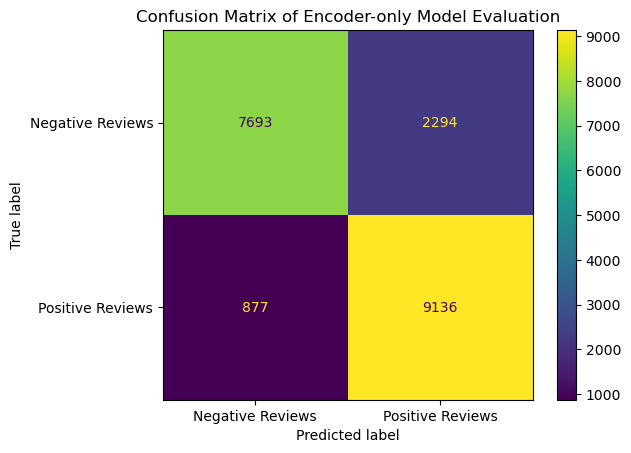

MISCLASSIFIED REVIEWS:
-----------------------

Misclassification nr.1:

True label: 0 --> Negative Review
Predicted label: 1 --> Positive Review

Actual review: i watched this film with a bunch of friends at a halloween party last night. i got to say that the sarcastic comments were never ending and i have to say that they were well deserved. though i felt that the directing was done well, the craziness in their dialogue is just a little too much cheese. i think i got about an hour into this before i even started to realize what it was the point was that they were trying to drive home. you catch on pretty quick that this whole family is pretty quirky and something is off about them, its just a little too slow. this movie could easily have been about 45 minutes and been a lot better. the only thing that made it bearable was the two bottles of wine that i downed during the course of the flick. bring on the slasher films folks, because at least i know what to expect out of them. this was

In [14]:
def visualize_evaluation(y_pred, y_true, num_reviews):
    visualize_confusion_mat(y_pred, y_true)
    print_misclassified_reviews(y_pred, y_true, num_reviews)


def visualize_confusion_mat(y_pred, y_true):
    #################################################################################################
    # Inspiration on confusion matrix from sklearn doc:                                             #
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html #
    #################################################################################################

    # Generate confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Generate confusion matrix display from confusion matrix
    display_conf_mat = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Negative Reviews", "Positive Reviews"])

    # Plot and visualize
    display_conf_mat.plot()
    plt.title("Confusion Matrix of Encoder-only Model Evaluation")
    plt.show()


def print_misclassified_reviews(y_pred, y_true, num_reviews):
    counter = 0
    mismatch_list = y_pred == y_true
    output_list = []
    
    # Go through the mismatch list 
    for i, match in enumerate(mismatch_list):
        if counter < num_reviews:
            # If pred and true is not a match
            if not match:
                counter += 1
                # Append to output list
                output_list.append((y_true[i], y_pred[i], dataset_test[i]["text"]))
        else:
            break

    # Output the specified number of missclassifications
    print("MISCLASSIFIED REVIEWS:\n-----------------------")
    for i, outputs in enumerate(output_list):
        label_map = ["Negative Review", "Positive Review"]
        true, pred, review = outputs
        print(f"\nMisclassification nr.{i+1}:\n")
        print(f"True label: {true} --> {label_map[true]}")
        print(f"Predicted label: {int(pred)} --> {label_map[int(pred)]}\n")
        print(f"Actual review: {review}\n\n")


def evaluate_model(model, test_loader, pad_id):
    model.eval()
    correct, total = 0, 0

    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader):
            attention_mask = create_mask(sequences, pad_id)
            outputs = model(sequences, mask=attention_mask)
            predictions = (outputs > 0.5).float()

            # Append curr prediticions and labels to list of all
            # predictions and labels respectively
            all_predictions.append(predictions)
            all_labels.append(labels)
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # Concatenate all predictions and labels to one tensor
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return correct / total, all_predictions, all_labels
    
# Evaluate model
accuracy, all_predictions, all_labels = evaluate_model(model, test_loader, PAD_ID)

# Print statistics, visualize confusion matrix and 5 misclassifications
print(f"Accuracy (test): {accuracy:.4f}")
visualize_evaluation(all_predictions, all_labels, 5)

### 2.7 Testing the Model on Custom Examples

For fun, we test the model on some custom examples from IMDb.

In [15]:
# Function to classify a single review
def classify_review(review, model, tokenizer, pad_idx, cls_idx, max_length):
    # Utilizing the preprocess_text(text)
    preprocessed_review = preprocess_text(review)
    
    # Reusing code from the IMDB dataset class to tokenize
    tokenized_review = tokenizer.encode(preprocessed_review).ids
    tokenized_review = [cls_idx] + tokenized_review[:max_length-1] + ([pad_idx]* max(0, (max_length-1) - len(tokenized_review)))
    tokenized_review = torch.tensor(tokenized_review).unsqueeze(0)

    # Reusing code from the evaluate_model function to predict
    model.eval()
    with torch.no_grad():
        attention_mask = create_mask(tokenized_review, pad_idx)
        p = model(tokenized_review, mask=attention_mask)
        sentiment = (p > 0.5).float()
    
    return sentiment, p

In [16]:
# Classifying reviews from one of our favorite movies Interstaller:
positive_IMDB_review_1_interstellar = '''Sometimes I just need to see the start. Or end. Or a trailer. Or the music and theme from Hans Zimmer. 
Or the whole movie. Just to feel that thing, I only get from this movie. That the earth, space and time are something special, mystical.
I never forget the first time I saw this movie, in an IMAX theatre in 2014. I was struck by it. Totally got me. 
And it stil does, 7 years later. This is the best movie ever made for me. Because of the feeling it gives me, no other movie can.
So hard to get all of this emotion in only one movie. Brilliant.'''

positive_IMDB_review_2_interstellar = '''After watching this insane movie in the theatres back in 2014 I swore to god I will wait 5 years to watch
it again so I get to forget it and experince the insanity it has again This without doubt is THE BEST MOVIE EVER MADE'''

positive_IMDB_review_3_interstellar = '''Amongst the best movies of all time. The story, the acting, the script, the cinematography,
the effects, the sound and the production as a whole is all absolute 10/10's. But what beats all of that is Hans Zimmers compositions.
How he continues to churn out perfection to the senses is mindblowing'''

In [17]:
label_map = ["Negative Review", "Positive Review"]

sentiment_1, p_1 = classify_review(review=positive_IMDB_review_1_interstellar, model=model, tokenizer=tokenizer,
                                  pad_idx=PAD_ID, cls_idx=CLS_ID, max_length=MAX_LENGTH)

sentiment_2, p_2 = classify_review(review=positive_IMDB_review_2_interstellar, model=model, tokenizer=tokenizer,
                                  pad_idx=PAD_ID, cls_idx=CLS_ID, max_length=MAX_LENGTH)

sentiment_3, p_3 = classify_review(review=positive_IMDB_review_3_interstellar, model=model, tokenizer=tokenizer,
                                  pad_idx=PAD_ID, cls_idx=CLS_ID, max_length=MAX_LENGTH)


print(f"\n\nInterstellar review nr. 1:\n-------------------------------\n")
print(f"Sentiment: {sentiment_1} --> {label_map[int(sentiment_1)]}\nProb. of positivity: {p_1:.3f}\n\n")

print(f"\n\nInterstellar review nr. 2:\n-------------------------------\n")
print(f"Sentiment: {sentiment_2} --> {label_map[int(sentiment_2)]}\nProb. of positivity: {p_2:.3f}\n\n")

print(f"\n\nInterstellar review nr. 3:\n-------------------------------\n")
print(f"Sentiment: {sentiment_3} --> {label_map[int(sentiment_3)]}\nProb. of positivity: {p_3:.3f}\n\n")



Interstellar review nr. 1:
-------------------------------

Sentiment: 1.0 --> Positive Review
Prob. of positivity: 0.982




Interstellar review nr. 2:
-------------------------------

Sentiment: 1.0 --> Positive Review
Prob. of positivity: 0.979




Interstellar review nr. 3:
-------------------------------

Sentiment: 1.0 --> Positive Review
Prob. of positivity: 0.988


